## Modeling 



In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('cleaned_data.csv',index_col='Dates',parse_dates=['Dates','Date'])

In [3]:
df.head(3)

,Unnamed: 0,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
Dates,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0,2096.0,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.0,220992.227
2014-01-01 01:00:00,1,1986.0,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.0,220992.227
2014-01-01 02:00:00,2,1936.0,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.0,220992.227


In [4]:
# Function for train and test split
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #index after which the test set starts
    
    
    if scale and include_test_scale:# StandardScaler fit on the entire dataset
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]
    
    
    if scale and not include_test_scale:# StandardScaler fit only on the training set
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test


In [5]:
# categorical colums creation
cat_cols = ['year', 'month', 'day', 'hour', 'weekday', 'season', 'holiday', 'non_working']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [6]:
#creating dummy columns for categorical variables
df_lr = pd.get_dummies(df,drop_first=True)

In [7]:
df_lr.columns

Index(['Unnamed: 0', 'SDGE', 'Date', 'STATION', 'DailyCoolingDegreeDays',
       'DailyHeatingDegreeDays', 'HourlyDryBulbTemperature', 'AC_kW',
       'cum_AC_kW', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_

In [8]:
df_lr.drop(['Date','STATION', 'AC_kW', 'DailyCoolingDegreeDays','DailyHeatingDegreeDays',           
              'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
              'weekday_Tuesday', 'weekday_Wednesday', 'holiday_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
               'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
               'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
               'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
               'day_28', 'day_29', 'day_30', 'day_31'], axis = 1, inplace = True)

In [9]:
cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW'] # other columns are binary values
X_train, X_test, y_train, y_test = train_test(df_lr, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

### Base line Model: Linear Regression

Text(0.5, 0, 'Features')

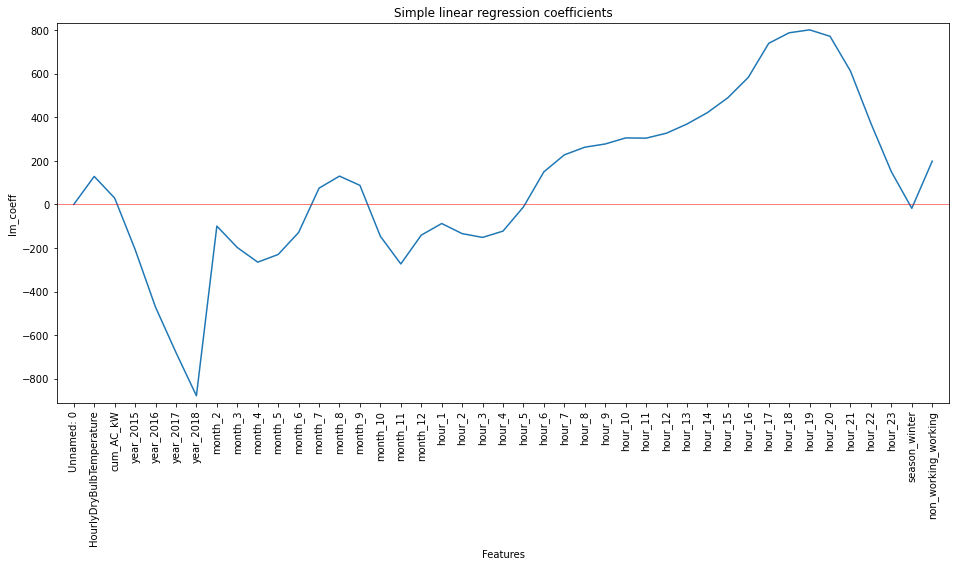

In [10]:
lrm = LinearRegression()
lrm.fit(X_train,y_train)

plt.figure(figsize = (16, 7))
plt.plot(range(len(X_train.columns)), lrm.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('Simple linear regression coefficients')
plt.ylabel('lm_coeff')
plt.xlabel('Features')

***most significant variable is the hour variable***

In [11]:
def performance(y_pred,y_true):
    r2 = r2_score(y_pred,y_true)
    mse = mean_squared_error(y_pred,y_true)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_pred,y_true)
    print(f'r2 = {r2},\n RMSE = {rmse},\n MAPE = {mape}')
    return 0

In [12]:
y_pred = lrm.predict(X_test)
performance(y_pred,y_test)

r2 = 0.6299304262964931,
 RMSE = 254.97731828570866,
 MAPE = 0.08259918698853044


0

### XGBoost Model

In [13]:
import xgboost as xgb

In [14]:
xgbtuned = xgb.XGBRegressor()

#hyperparameter tuning
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}


In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [16]:
tscv = TimeSeriesSplit(n_splits=3) # time series cross validation split
xgbtunedreg = RandomizedSearchCV(xgbtuned, param_distributions=param_grid , 
                                   scoring='neg_mean_squared_error', n_iter=20, n_jobs=-1, 
                                   cv=tscv, verbose=2, random_state=42)

In [18]:
xgbtunedreg.fit(X_train, y_train)
best_score = xgbtunedreg.best_score_
best_params = xgbtunedreg.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best score: -37275.8293409106
Best params: 
colsample_bylevel: 0.9
colsample_bytree: 0.8
gamma: 0.25
learning_rate: 0.3
max_depth: 3
min_child_weight: 0.5
n_estimators: 115
subsample: 1.0


In [19]:
xgbmodel = xgb.XGBRegressor(colsample_bylevel= 0.9,colsample_bytree= 0.8,gamma= 0.25,learning_rate= 0.3,max_depth= 3,min_child_weight= 0.5,n_estimators= 115,subsample=1.0)
xgbmodel.fit(X_train,y_train)
y_predict_xgb = xgbmodel.predict(X_test)
performance(y_predict_xgb,y_test)

r2 = 0.8070674335480545,
 RMSE = 199.1874203067829,
 MAPE = 0.06456523004590445


0

### Modeling Seasonalities and Lagged values


#### Multiple Seasonalities with Fourier Series
$ g(t) = \Sigma a_m cos(2 \pi m t / T) + \Sigma b_n sin (2\pi nt / T)$

$m, n $ are descrete values, chosen as m=n=5 (by trial and error and referring literature works),
Daily : $T = 24$
Yealry: $T = 365.35 $
Weekly :$T= 7 $


In [20]:
def add_fourier_terms(df, year_k, week_k, day_k):
    for k in range(1, year_k+1):
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)
    for k in range(1, week_k+1):
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)
    for k in range(1, day_k+1):
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)

#### Adding Lagged Values

The energy consumption values can also be expected to depend on it’s previous lagged values because the energy consumption of a region shouldn’t be expected to change much in the next few hours except for any unexpected or unfortunate events. So we will add the lagged values of energy consumption as the X parameters and check if we can predict better using the past values (in addition to the variables that we had already added).

lag1 is the value of the energy consumption in the previous hour, lag2 is the value of energy consumption
2 hours before the current value and so on

In [21]:
for i in range(24):
    df_lr['lag'+str(i+1)] = df_lr['SDGE'].shift(i+1)
    #Since the first 24 values won't have any 24th lag, they will be NaN. So dropping the NaNs 
lag_df = df_lr.dropna()

In [22]:
lag_df.head(3)

,Unnamed: 0,SDGE,HourlyDryBulbTemperature,cum_AC_kW,year_2015,year_2016,year_2017,year_2018,month_2,month_3,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00,24,1904.0,53.0,221141.892,0,0,0,0,0,0,...,2250.0,2141.0,2055.0,2011.0,1922.0,1899.0,1896.0,1936.0,1986.0,2096.0
2014-01-02 01:00:00,25,1855.0,52.0,221141.892,0,0,0,0,0,0,...,2304.0,2250.0,2141.0,2055.0,2011.0,1922.0,1899.0,1896.0,1936.0,1986.0
2014-01-02 02:00:00,26,1815.0,54.0,221141.892,0,0,0,0,0,0,...,2301.0,2304.0,2250.0,2141.0,2055.0,2011.0,1922.0,1899.0,1896.0,1936.0


*Adding Fourier Terms to the data frame with lagged values*

In [27]:
add_fourier_terms(lag_df, year_k= 5, week_k=5 , day_k=5)


### Improved XGBoost Model, with Fourier Series and Lagged Values

In [28]:
X_trainF, X_testF, y_trainF, y_testF = train_test(lag_df, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

In [29]:
xgbtunedreg.fit(X_trainF, y_trainF)
best_score = xgbtunedreg.best_score_
best_params = xgbtunedreg.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best score: -2336.508231199175
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.9
gamma: 0.5
learning_rate: 0.3
max_depth: 6
min_child_weight: 7.0
n_estimators: 115
subsample: 0.9


In [30]:
xgbfmodel = xgb.XGBRegressor(colsample_bylevel= 0.6,colsample_bytree= 0.9,gamma= 0.5,learning_rate= 0.3,max_depth= 6,min_child_weight= 7,n_estimators= 115,subsample=0.9)
xgbfmodel.fit(X_trainF,y_trainF)
y_predict_xgbf = xgbfmodel.predict(X_testF)
performance(y_predict_xgbf,y_testF)

r2 = 0.9905738258960164,
 RMSE = 47.44124169059847,
 MAPE = 0.01447405390505274


0

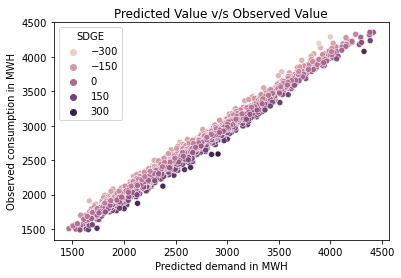

In [41]:
f1=sns.scatterplot(y_predict_xgbf,y_testF,hue=(y_predict_xgbf-y_testF))
plt.title('Predicted Value v/s Observed Value')
plt.xlabel('Predicted demand in MWH')
plt.ylabel('Observed consumption in MWH')
plt.show()

In [42]:
print(f'change in r2 from LR model= {0.9905738258960164-0.6299304262964931} increase')
print(f'change in RMSE from LR model= {254.97731828570866 -47.44124169059847 } decrease')
print(f'change in MAPE from LR model= {8.2599186988 -001.447405390505274 } % decrease')

change in r2 from LR model= 0.3606433995995233 increase
change in RMSE from LR model= 207.5360765951102 decrease
change in MAPE from LR model= 6.812513308294726 % decrease
